In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, execute
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

# Original routine defined in this repo
from utils.dynamics import plot_heisenberg_spins

$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\upket}{\ket{\!\uparrow}}$
$\newcommand{\downket}{\ket{\!\downarrow}}$
$\newcommand{\rightket}{\ket{\!\rightarrow}}$
$\newcommand{\leftket}{\ket{\!\leftarrow}}$

# Dynamics simulation of the Heisenberg model

## The Hamiltonian

$$
H = -J \sum_{j=0}^{n-2} (\sigma^X_j\sigma^X_{j+1} + \sigma^Y_j\sigma^Y_{j+1} + \sigma^Z_j \sigma^Z_{j+1})
$$

The $j$th term is actually

$$
I_0 \otimes \dots \otimes I_{j-1} \otimes \sigma^X_j \otimes \sigma^X_{j+1} \otimes I_{j+2} \otimes \dots I_{n-1}
$$

The time evolution operator is

$$
U_H(t) = \exp \left[ \frac{i\omega t}{2} \sum_{j=0}^{n-2} (\sigma^X_j\sigma^X_{j+1} + \sigma^Y_j\sigma^Y_{j+1} + \sigma^Z_j \sigma^Z_{j+1}) \right]
$$

Since the terms in the Hamiltonian do not commute with each other, we resort to Trotterization.

$$
\tilde{U}_{H;\Delta t} = \prod_{j=0}^{n-2} \exp\left( \frac{i \omega \Delta t}{2} \sigma^X_j\sigma^X_{j+1} \right) \exp\left( \frac{i \omega \Delta t}{2} \sigma^Y_j\sigma^Y_{j+1} \right) \exp\left( \frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1} \right)
$$

## Expression in quantum gates

Map: spin $+Z \leftrightarrow \ket{0}$, spin $-Z \leftrightarrow \ket{1}$

Then $\sigma^{X,Y,Z} \leftrightarrow X, Y, Z$ (quantum gates).

### Discrete (non-parametric) gates

- $X$
  $$
    X\ket{0} = \ket{1} \\
    X\ket{1} = \ket{0}
  $$
- $Y$
  $$
    Y\ket{0} = i\ket{1} \\
    Y\ket{1} = -i\ket{0}
  $$
- $Z$
  $$
    Z\ket{0} = \ket{0} \\
    Z\ket{1} = -\ket{1}
  $$
- $H$ (Hadamard)
  $$
    H\ket{0} = \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \\
    H\ket{1} = \frac{1}{\sqrt{2}} (\ket{0} - \ket{1})
  $$
  
### Rotation gates

= Exponentiated $X, Y,$ and $Z$ gates

- $R_{y}(\theta) = \exp\left(-i \theta / 2 Y \right)$
  $$
    R_{y}(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} + \sin\frac{\theta}{2}\ket{1} \\
    R_{y}(\theta)\ket{1} = -\sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
  $$
- $R_{z}(\phi) = \exp\left(-i \phi / 2 Z \right)$
  $$
    R_{z}(\phi)\ket{0} = e^{-i\phi/2}\ket{0} \\
    R_{z}(\phi)\ket{1} = e^{i\phi/2}\ket{1}
  $$
- $P(\phi) = \exp\left(-i \phi / 2 (Z - I) \right)$
  
### Controlled gates

Gate $C^i_j[U]$ acts on qubits $i$ and $j$ as

$$
\begin{align}
C^i_j[U](\ket{0}_i\ket{0}_j) & = \ket{0}_i\ket{0}_j \\
C^i_j[U](\ket{0}_i\ket{1}_j) & = \ket{0}_i\ket{1}_j \\
C^i_j[U](\ket{1}_i\ket{0}_j) & = \ket{1}_iU\ket{0}_j \\
C^i_j[U](\ket{1}_i\ket{1}_j) & = \ket{1}_iU\ket{1}_j
\end{align}
$$
  
### Individual terms in the Hamiltonian

$\exp(\frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1})$ acts on spins $j$ and $(j+1)$ as

$$
\begin{align}
\upket_j \upket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \upket_j \upket_{j+1} \\
\upket_j \downket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \upket_j \downket_{j+1} \\
\downket_j \upket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \downket_j \upket_{j+1} \\
\downket_j \downket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \downket_j \downket_{j+1}
\end{align}
$$

i.e. applies an opposite phase according to the parity of the spins.

To perform operations according to the parity of the qubits, we can use the $C[X]$ (CNOT) gate.

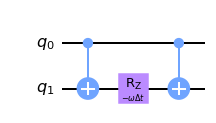

In [2]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.draw('mpl')

The circuit above acts on computational bases $\ket{00}, \ket{01}, \ket{10}, \ket{11}$ as

$$
\begin{align}
\ket{00} \rightarrow e^{i \omega \Delta t / 2} \ket{00} \\
\ket{01} \rightarrow e^{-i \omega \Delta t / 2} \ket{01} \\
\ket{10} \rightarrow e^{-i \omega \Delta t / 2} \ket{10} \\
\ket{11} \rightarrow e^{i \omega \Delta t / 2} \ket{11}
\end{align}
$$

which is exactly the expression of $\exp(\frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1})$.

The other two operators in the Hamiltonian ($\exp(XX)$ and $\exp(YY)$) also act on the parity, but everything in quantum computer must be expressed in Z basis. We therefore rotate the spins beforehand as follows.

For $\exp(\frac{i \omega \Delta t}{2} \sigma^X_j\sigma^X_{j+1})$

$$
\begin{align}
\rightket_j \rightket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \rightket_j \rightket_{j+1} \\
\rightket_j \leftket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \rightket_j \leftket_{j+1} \\
\leftket_j \rightket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \leftket_j \rightket_{j+1} \\
\leftket_j \leftket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \leftket_j \leftket_{j+1}
\end{align}
$$

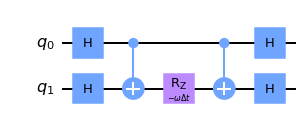

In [3]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.h(0)
circuit.h(1)
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.h(0)
circuit.h(1)
circuit.draw('mpl')

For $\exp(\frac{i \omega \Delta t}{2} \sigma^Y_j\sigma^Y_{j+1})$

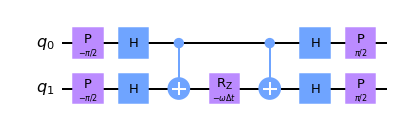

In [4]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.p(-np.pi / 2., 0)
circuit.p(-np.pi / 2., 1)
circuit.h(0)
circuit.h(1)
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.h(0)
circuit.h(1)
circuit.p(np.pi / 2., 0)
circuit.p(np.pi / 2., 1)
circuit.draw('mpl')

### Qiskit implementation

We'll execute the circuit on a simulator as well as real quantum hardware.

Let $n=5$, $M=10$, $\omega \Delta t = 0.1$ and the initial state is $\frac{1}{\sqrt{2}}(\upket + \downket)$ on qubit 0 and $\upket$ for the remainder.

In [5]:
n = 5 # number of qubits
M = 10 # number of Trotter steps
omegadt = 0.1 # Trotter step

circuits = []

circuit = QuantumCircuit(n) # |0>|0>...

# Bit 0 in state 1/sqrt(2)(|0> + |1>)
circuit.h(0)

for istep in range(M):
    for j in range(n - 1):
        # ZZ
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)

        # XX
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)

        # YY
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., j + 1)

    # Save a copy of the circuit at this point
    # measure_all(inplace=False) creates a copy of the circuit with a full measurement at the end
    circuits.append(circuit.measure_all(inplace=False))
    
print('{} circuits created'.format(len(circuits)))

10 circuits created


Plotting the expectation value of the $Z$ component of each spin at each time slice:

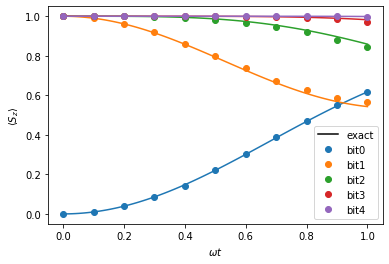

In [6]:
shots = 100000

qasm_simulator = Aer.get_backend('qasm_simulator')

sim_job = execute(circuits, qasm_simulator, shots=shots)
sim_counts_list = sim_job.result().get_counts()

# Initial statevector for the theory curve in the plot
initial_state = np.zeros(2 ** n, dtype=np.complex128)
initial_state[0:2] = np.sqrt(0.5)
   
plot_heisenberg_spins(sim_counts_list, n, initial_state, omegadt, add_theory_curve=True)

Now we'll run the same circuit on a QV32 5-qubit machine:

In [7]:
# IBMQ.enable_account('__your_ibmq_token__')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_filter = lambda b: (not b.configuration().simulator) and b.configuration().n_qubits >= n and b.configuration().quantum_volume >= 32 and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

print('Will use backend', backend.name())

job = execute(circuits, backend, shots=8192, optimization_level=3)

job_monitor(job, interval=2)

counts_list = job.result().get_counts()

Job Status: job has successfully run


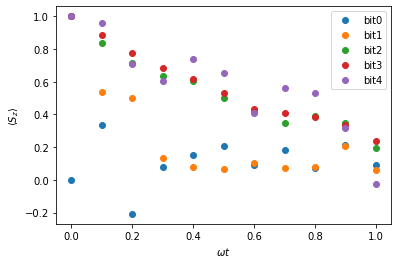

In [8]:
plot_heisenberg_spins(counts_list, n, initial_state, omegadt)